# **Collecte de données**

In [23]:
import os, sys
from PIL import Image
from PIL.ExifTags import TAGS
chemin_image='./cattt'
for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        try:
            imgfile = Image.open(filepath)
            # Recupérer les métadonnées EXIF
            exif_data = imgfile._getexif()
            if exif_data is None:
                 continue
            if exif_data:
                print("Métadonnées pour l'image {filename}:")
            for tag,value in exif_data.items():
                if tag in TAGS:
                    print(f"{TAGS[tag]}: {value}")
                else:
                    print(f"Aucune métadonné EXIF disponible pour l'image {imgfile}.")
        except (OSError, AttributeError)as e:
                print(f"Impossible de traiter l'image {imgfile}.{e}")



Nous n'avons aucune image avec un exif donc nous passons par uen autre méthode

In [1]:
import os, sys
from PIL import Image
from PIL.ExifTags import TAGS

chemin_image='./cattt'
chemin_json='./metadonnees_images.json'

metadatalist=[]

for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        try:
            img = Image.open(filepath)
            metadata={
                 'file_name': fichier,
                 'size': img.size,
                 'format': img.format,
                 'mode': img.mode,
                 'exif': None
            }

            metadatalist.append(metadata)

        except (OSError, AttributeError)as e:
                print(f"Impossible de traiter l'image {imgfile}.{e}")

Après avoir reccuperer les donnees nous demondons aux utilisateurs de choisir des images

In [3]:
import ipywidgets as widgets
import os, sys
from PIL import Image

from os import listdir

chemin_image='./cattt'
images = []

for file in os.listdir(chemin_image):
    if file.endswith('.jpg') :
        images.append("./cattt/" + file)

from ipywidgets import GridspecLayout, Image, interact
paths = []

checkboxes = [widgets.Checkbox(value=False, description='Favorite') for _ in range(len(images))]

# Create the GridspecLayout widget
layout = GridspecLayout(n_columns=2, n_rows=len(images), width='400px')
for i, (img, checkbox) in enumerate(zip(images, checkboxes)):
  file = open(img, "rb")
  image = file.read()
  image_widget = widgets.Image(
    value=image,
    format='png',
    width=100,
    height=100,
  )
  layout[i,0] = image_widget
  layout[i, 1] = checkbox

# Button to get selected images
button = widgets.Button(description="Select")

# Output widget to display selected images
output = widgets.Output()

# Function to get selected images
def get_selected_images(btn):
    global paths
    paths = []
    selected_paths = [images[i] for i, checkbox in enumerate(checkboxes) if checkbox.value]
    with output:
        output.clear_output()
        print("Selected Images:")
        for path in selected_paths:
            print(path)
            paths.append(path)
    print(paths)
        

# Link button click event to function
button.on_click(get_selected_images)

# Display the layout and button
display(layout, button, output)


GridspecLayout(children=(Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00H\x00H\x00\x00\xff\xdb\…

Button(description='Select', style=ButtonStyle())

Output()

['./cattt/00000003_020.jpg', './cattt/00000007_012.jpg', './cattt/00000015_000.jpg']


./cattt/00000016_022.jpg


AttributeError: 'Text' object has no attribute 'show'

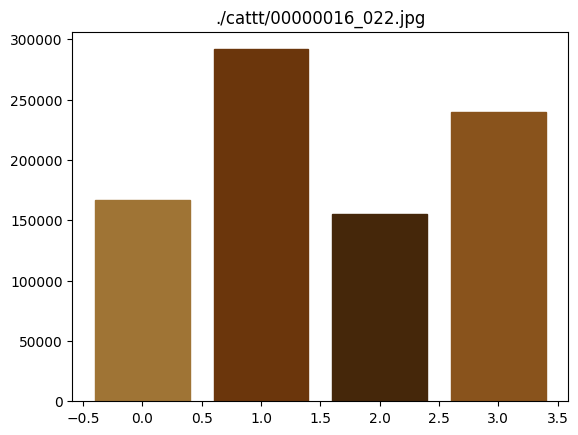

In [3]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
import os
from sklearn.cluster import KMeans

chemin_image='./cattt'

for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        print(filepath)
        imgfile = Image.open(filepath)
        numarray = numpy.array(imgfile.getdata(), numpy.uint8)
        clusters = KMeans(n_clusters=4, n_init=2)
        clusters.fit(numarray)
        npbins = numpy.arange(0, 5)
        histogram = numpy.histogram(clusters.labels_, bins=npbins)
        labels = numpy.unique(clusters.labels_)
        barlist = plot.bar(labels, histogram[0])
        for i in range(4):
            barlist[i].set_color(
                "#%02x%02x%02x"
                % (
                    math.ceil(clusters.cluster_centers_[i][0]),
                    math.ceil(clusters.cluster_centers_[i][1]),
                    math.ceil(clusters.cluster_centers_[i][2]),
                )
            )
        plot.title(filepath,loc='center')
        plot.show()



Visualisation des données 

In [10]:
from PIL import Image
import numpy
import math
import matplotlib.pyplot as plot
import os
from sklearn.cluster import KMeans

for fichier in os.listdir(chemin_image):
    if fichier.endswith('.jpg') :
        filepath = os.path.join(chemin_image, fichier)
        imgfile = Image.open(fichier)
        histogram = imgfile.histogram()
        red = histogram[0:255]
        green = histogram[256:511]
        blue = histogram[512:767]
        x = range(255)
        y = []
        for i in x:
            y.append((red[i], green[i], blue[i]))
        figure, axes = plot.subplots()
        axes.set_prop_cycle("color", ["red", "green", "blue"])
        plot.plot(x, y)
        plot.show()


FileNotFoundError: [Errno 2] No such file or directory: '00000016_022.jpg'